## Latent visualization space
Script for visualizing latent space for the RNNVAE. Visualization of selected dimensions, over time, testing visualization, colors, the like. Testing for multi channel



In [1]:
#Import
# working dir
%cd /homedtic/gmarti/CODE/RNN-VAE/

# Imports
import sys
sys.path.insert(0, '/homedtic/gmarti/CODE/RNN-VAE/')
from rnnvae.utils import open_MRI_data_var
from rnnvae import rnnvae
from rnnvae.plot import plot_losses, plot_trajectory, plot_total_loss, plot_z_2d, plot_z_time_2d, plot_latent_space
import os
import math
from rnnvae.data_gen import SinDataGenerator
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import torch

%matplotlib inline

/homedtic/gmarti/CODE/RNN-VAE


In [2]:
# DEVICE
## Decidint on device on device.
DEVICE_ID = 0
DEVICE = torch.device('cuda:' + str(DEVICE_ID) if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_ID)

print(DEVICE)

out_dir = "experiments_mc/meta_synth_nopadding/_h_2_z_3_hid_10_ntp_10_n_300/"

#load parameters
p = eval(open(out_dir + "params.txt").read())
print(p['curves'])

model = rnnvae.MCRNNVAE(p["h_size"], p["hidden"], p["n_layers"], 
                        p["hidden"], p["n_layers"], p["hidden"],
                        p["n_layers"], p["z_dim"], p["hidden"], p["n_layers"],
                        p["clip"], p["n_epochs"], p["batch_size"], 
                        p["n_channels"], p["n_feats"], p["model_name_dict"], DEVICE)
model = model.to(DEVICE)
model.load(out_dir+'model.pt')

cuda:0
[[('sigmoid', {'L': 1, 'k': 1, 'x0': 5}), ('sin', {'A': 1, 'f': 0.2}), ('cos', {'A': 1, 'f': 0.2})], [('sigmoid', {'L': 1, 'k': -15, 'x0': 5}), ('sigmoid', {'L': 1, 'k': 5, 'x0': 5})]]


In [3]:
X_samples_tensor = []
nsamples = 500
#generate the data
for ch_curves in p['curves']:
    gen_model = SinDataGenerator(ch_curves, p["ntp"], p["noise"])
    samples = gen_model.generate_n_samples(nsamples)
    X_samples = np.asarray([y for (_,y) in samples])
    X_samples_tensor.append(torch.FloatTensor(X_samples).permute((1,0,2)).to(DEVICE))

# Predict the reconstructions from X_val and X_train
X_sample = model.predict(X_samples_tensor, p['ntp'])

#Get the samples
X_pred = [np.array(x).swapaxes(0,1) for x in X_sample['xnext']]
z_sample = [np.array(x).swapaxes(0,1) for x in X_sample['z']]

In [4]:
# Test the new function of latent space
qzx = [np.array(x) for x in X_sample['qzx']]
print(len(qzx))
print(len(qzx[0]))
# Get classificator labels, for n time points
classif = [[i]*nsamples for i in range(p["ntp"])]
classif = [item for elem in classif for item in elem]

2
10


2
(500, 10, 3)
2
(500, 10, 3)


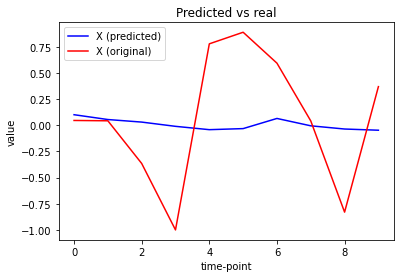

In [31]:
# Test reconstruction of samples
#Generate data, with different parameters
n_rec_tp = 10
X_samples_tensor = []
X_samples_notensor = []
nsamples = 500
#generate the data
for ch_curves in p['curves']:
    gen_model = SinDataGenerator(ch_curves, n_rec_tp, 0)
    samples = gen_model.generate_n_samples(nsamples)
    X_samples = np.asarray([y for (_,y) in samples])
    X_samples_tensor.append(torch.FloatTensor(X_samples).permute((1,0,2)).to(DEVICE))
    X_samples_notensor.append(X_samples)
# Predict the reconstructions from X_val and X_train

X_fwd = model.predict(X_samples_tensor, n_rec_tp)

#Reformulate things
X_pred = [np.array(x).swapaxes(0,1) for x in X_sample['xnext']]

print(len(X_pred))
print(X_pred[0].shape)

print(len(X_samples_notensor))
print(X_samples_notensor[0].shape)


feat = 2
subj = 21
channel = 0

X_hat_line = X_pred[channel][subj,:,feat]   #Select only the subject we want
X_samples_line = X_samples_notensor[channel][subj,:,feat]   #Select only the subject we want

# Plot the two lines
plt.plot(range(len(X_hat_line)), X_hat_line, '-b', label='X (predicted)')
plt.plot(range(len(X_samples_line)), X_samples_line, '-r', label='X (original)')

plt.xlabel("time-point")
plt.ylabel("value")

plt.legend(loc='upper left')
plt.title("Predicted vs real")
plt.show()

2
(500, 10, 3)
2
(500, 10, 3)
(10,)
(10,)


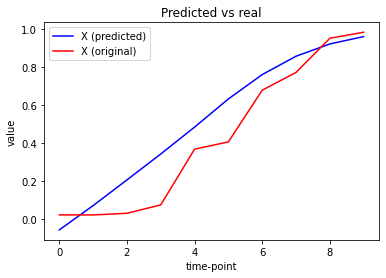

In [37]:
#Reconstruct one channel from the other
"""
n_rec_tp = 10
X_samples_tensor = []
X_samples_notensor = []
nsamples = 500
#generate the data
for ch_curves in p['curves']:
    gen_model = SinDataGenerator(ch_curves, n_rec_tp, 0)
    samples = gen_model.generate_n_samples(nsamples)
    X_samples = np.asarray([y[:5] for (_,y) in samples])
    X_samples_tensor.append(torch.FloatTensor(X_samples).permute((1,0,2)).to(DEVICE))
    X_samples_notensor.append(X_samples)
""" 
# Predict the reconstructions from X_val and X_train
X_fwd = model.predict(X_samples_tensor, n_rec_tp, av_ch=[0])

#Reformulate things
X_fwd = [np.array(x).swapaxes(0,1) for x in X_fwd['xnext']]

print(len(X_fwd))
print(X_fwd[0].shape)

print(len(X_samples_notensor))
print(X_samples_notensor[0].shape)


feat = 0
subj = 21
channel = 0

X_hat_line = X_fwd[channel][subj,:,feat]   #Select only the subject we want
X_samples_line = X_samples_notensor[channel][subj,:,feat]   #Select only the subject we want

print(X_hat_line.shape)
print(X_samples_line.shape)

# Plot the two lines
plt.plot(range(len(X_hat_line)), X_hat_line, '-b', label='X (predicted)')
plt.plot(range(len(X_samples_line)), X_samples_line, '-r', label='X (original)')

plt.xlabel("time-point")
plt.ylabel("value")

plt.legend(loc='upper left')
plt.title("Predicted vs real")
plt.show()